Let's get SU/RE trendlines
--

This notebook has the purpose of allowing others to collaborate on this research. 

This code is POC, not optimized, not even usable yet.



In [1]:
%matplotlib inline

from IPython.display import display, HTML

import os

import json

from pandas import DataFrame, Series, to_datetime, isna, notna
import numpy as np

import time
from datetime import datetime

path = '/home/bruno/Documentos/work/bitcoins/traders/freqtrade/user_data/data/binance/'
pair = 'ETH_BTC'
ticker_interval = '15m'
file = os.path.join(path, f'{pair}-{ticker_interval}.json')


with open(file) as tickerdata:
    pairdata = json.load(tickerdata)

# print (pairdata[-2])

def parse_ticker_dataframe(ticker: list) -> DataFrame:
    cols = ['date', 'open', 'high', 'low', 'close', 'volume']
    frame = DataFrame(ticker, columns=cols)

    frame['date'] = to_datetime(frame['date'],
                                unit='ms',
                                utc=True,
                                infer_datetime_format=True)

    # group by index and aggregate results to eliminate duplicate ticks
    frame = frame.groupby(by='date', as_index=False, sort=True).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'max',
    })
    frame.drop(frame.tail(1).index, inplace=True)     # eliminate partial candle
    return frame

/home/bruno/miniconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_trends(df, interval: int, pair: str=None, filename: str=None, cols=[]):
    plt.figure(num=0, figsize=(50,30))
    # df['old_date'] = df['date']
    # to_datetime(df['date'])
    # df.set_index(['date'],inplace=True)
#     for c in cols:
#         plt.scatter(df.index, df[c], color='r', label=c, s=10)
    
    if 's1_trend' in df:
        plt.plot(df['s1_trend'], color='g', label='support trend')
    if 'r1_trend' in df:
        plt.plot(df['r1_trend'], color='r', label='res trend')
    plt.plot(df.high, 'r', alpha=0.5)
    plt.plot(df.close, 'k', alpha=0.5)
    plt.plot(df.low, 'g', alpha=0.5)

#     plt.plot(df.bb_lower, 'b', alpha=0.5, linewidth=2)
#     plt.plot(df.bb_upper, 'b', alpha=0.5, linewidth=2)

    trends = [col for col in df if col.startswith('trend|')]
    for t in trends:
        plt.plot(df.index, df[t], 'k', label='trend', alpha=0.2, linewidth=1)
#         data_name = 'data_'+t+'|su'
#         if np.count_nonzero(np.where(df[data_name]==1)) > 2:
#             plt.plot(df.index, df[t], 'k', label='trend', alpha=0.5, linewidth=1)

    plt.xlim(df.index[0], df.index[-1])
    plt.ylim(df.low.min()*0.99, df.high.max()*1.01)
    plt.xticks(rotation='vertical')

    if not filename:
        filename = 'chart_plots/' + pair.replace('/', '-') + '-' +  interval + \
                str(len(df)) + datetime.utcnow().strftime('-%H') + '.png'
    if 'fractals' in df:
        res_pivots = df['fractals'] == 1
        sup_pivots = df['fractals'] == -1

        plt.scatter(df.index[res_pivots], df.high[res_pivots], color='r', s=5)
        plt.scatter(df.index[sup_pivots], df.low[sup_pivots], color='g', s=5)
    if 'pivots' in df:
        res_pivots = df['pivots'] == 1
        sup_pivots = df['pivots'] == -1

        plt.scatter(df.index[res_pivots], df.high[res_pivots], color='k', s=30)
        plt.scatter(df.index[sup_pivots], df.low[sup_pivots], color='k', s=30)

#     plt.savefig(filename)
    plt.show()
    plt.close()

In [3]:
from user_data.indicators.trendlines import *



# df, pivots = get_pivots_OHCL(df, period=20, stdv= 1.2, 
#             interval=ticker_interval, thresh_type = 'dynamic',
#             thresh_up = 0.005, thresh_down = -0.005,
#             chart=False, pair=pair)

df = parse_ticker_dataframe(pairdata)

# df_concurrence = get_trends_OHCL(df_concurrence,
#             interval=ticker_interval, pivot_type='pivots',
#             tolerance=0.01, su_min_tests=3, re_min_tests=3, body_min_tests=1, ticker_gap = 1, fake=0.005, nearby=0.005,
#             angle_max = 92, angle_min = 45,
#             thresh_up = 0.01, thresh_down = -0.01,
#             chart=False, pair=pair)


df_lightbuoy = get_trends_lightbuoy_OHCL(df,
            interval=ticker_interval, pivot_type='fractals',
            pressision=0.00001, su_min_tests=3, re_min_tests=1, body_min_tests=1, ticker_gap = 1, fake=0.0001, nearby=0.00001,
            angle_max = 100, angle_min = 70,
            thresh_up = 0.01, thresh_down = -0.01,
            chart=False, pair=pair)

finding trends - lightbuoy style
                                        name interval                 a  \
0             trend|1|0.069502|4|0.0695|90.0      15m     [1, 0.069502]   
1                                        NaN      NaN               NaN   
2                trend|4|0.0695|4|0.0695|0.0      15m       [4, 0.0695]   
3                                        NaN      NaN               NaN   
4            trend|4|0.0695|11|0.069807|90.0      15m       [4, 0.0695]   
5                                        NaN      NaN               NaN   
6            trend|4|0.0695|15|0.069578|90.0      15m       [4, 0.0695]   
7                                        NaN      NaN               NaN   
8            trend|4|0.0695|18|0.069555|90.0      15m       [4, 0.0695]   
9                                        NaN      NaN               NaN   
10            trend|4|0.0695|22|0.06936|90.0      15m       [4, 0.0695]   
11                                       NaN      NaN              

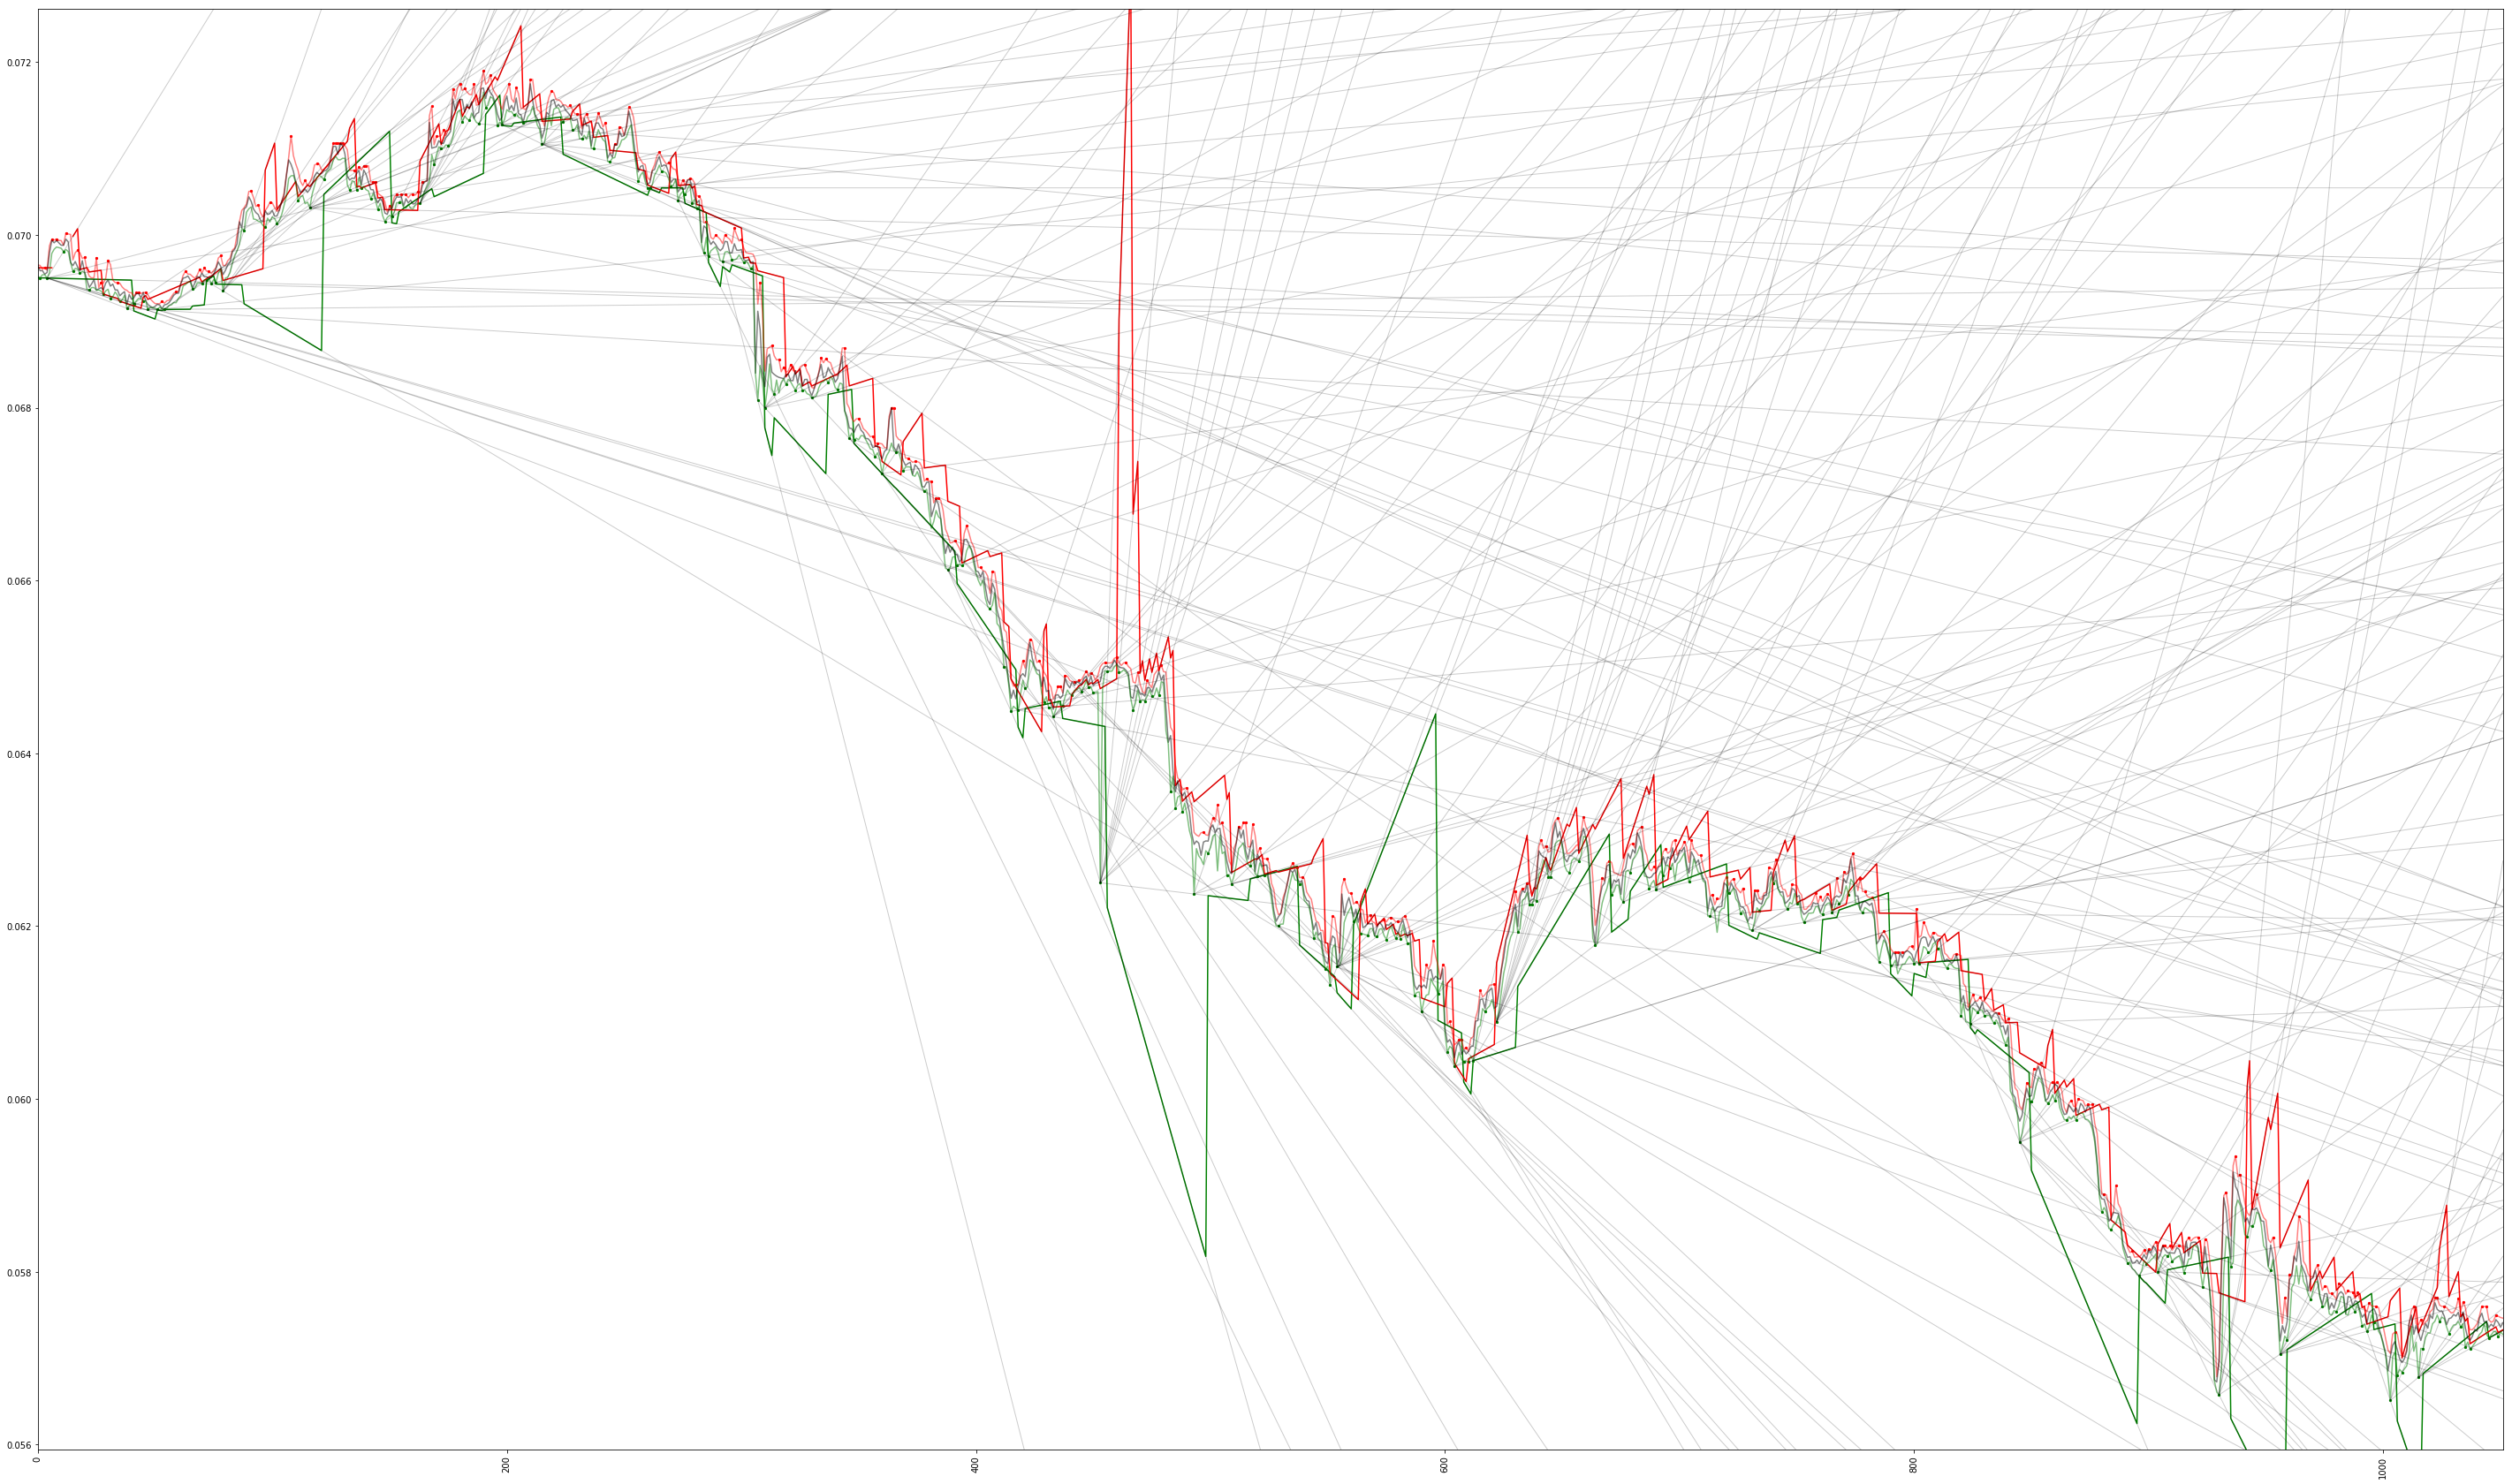

In [4]:
# plot_trends(df_concurrence, interval=ticker_interval, pair=pair, cols=[])
plot_trends(df_lightbuoy, interval=ticker_interval, pair=pair, cols=[])

In [5]:
max_drawdown(df.close.values)

0.20938562747393666